In [110]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torch import Tensor
from torch.nn.init import xavier_normal

from torch.utils.data import DataLoader, Dataset

import numpy as np

import os
import random

from tqdm import tqdm_notebook

from pycrayon import CrayonClient

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

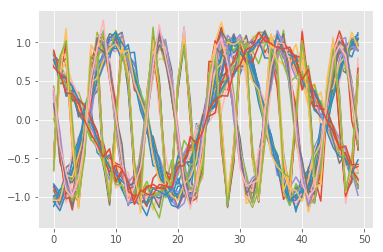

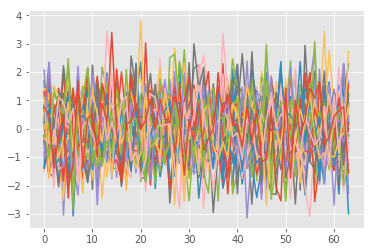

In [123]:
D_hid = 32
G_hid = 512 

mb_size = 64
seq_len = 50
z_dim = 50
c_dim = 10
n_classes = 4


rs = (-4,4)
rf = (5,50)


def g_noise():
    return (torch.randn(mb_size, z_dim))
    
    
def real_sample():
    shift_choices = [-1, 2, -3.14/2]
    freq_choices = [4, 16, 8, 32]
    
    #labels = list(range(len(shift_choices)))
    #lookup = {shift: label for shift, label in zip(shift_choices, labels)}
    labels = list(range(len(freq_choices)))
    lookup = {freq: label for freq, label in zip(freq_choices, labels)}
    
    #shift = np.random.choice(shift_choices, mb_size)
    shift = np.ones(mb_size) * -3.14/2
    #freq = np.ones(mb_size) * 3
    freq = np.random.choice(freq_choices, mb_size)
    
    support = np.linspace(-1, 1, seq_len)
    seqs = np.array([np.sin((support + shift[i])*freq[i]) 
                   for i in range(mb_size)])
    seqs += np.random.normal(size=seqs.shape) * 1e-1
    #shift = [lookup[s] for s in shift]
    freq = [lookup[f] for f in freq]
    return Tensor(seqs), torch.LongTensor(freq)

u, s = real_sample()
u = u.numpy()
plt.plot(u.T)
plt.show()

v = g_noise().numpy()
plt.plot(v)
plt.show()

In [124]:
class Logger():
    def __init__(self, exp_name):
        self.cc = CrayonClient(hostname='localhost')
        names = self.cc.get_experiment_names()
        self.cc.remove_experiment(exp_name)
        self.exp = self.cc.create_experiment(exp_name)
        
    def log_scalar(self, key, val):
        self.exp.add_scalar_value(key, val)
        
    def log_hist(self, key, val):
        self.exp.add_histogram_value(key, val, tobuild=True)

In [125]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(n_classes, c_dim)
        self.l1 = nn.Linear(z_dim + c_dim, G_hid)
        self.l2 = nn.Linear(G_hid, G_hid)
        self.l3 = nn.Linear(G_hid, seq_len)
        
    def forward(self, z, c=None):
        c = self.embed(c)
        inp = torch.cat([z, c], 1)
        h = F.relu(self.l1(inp))
        h = F.relu(self.l2(h))
        output = F.tanh(self.l3(h))
        return output
    
    def init_weights(self):
        for name, param in self.named_parameters(): 
            if param.dim() >= 2:
                xavier_normal(param)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__() 
        self.embed = nn.Embedding(n_classes, c_dim)
        self.l1 = nn.Linear(seq_len + c_dim, D_hid)
        self.l2 = nn.Linear(D_hid, 1)
    
    def forward(self, X, c=None):
        c = self.embed(c)
        inp = torch.cat([X, c], 1)
        h = F.relu(self.l1(inp))
        y = F.sigmoid(self.l2(h))
        return y
    
    def init_weights(self):
        for name, param in self.named_parameters(): 
            if param.dim() >= 2:
                xavier_normal(param)
    
G = Generator()
G.init_weights()
D = Discriminator()
D.init_weights()
G.cuda()
D.cuda()

ones_label = Variable(torch.ones(mb_size, 1)).cuda()
zeros_label = Variable(torch.zeros(mb_size, 1)).cuda()

G_solver = optim.SGD(G.parameters(), lr=1e-4)
D_solver = optim.Adamax(D.parameters(), lr=1e-3)
#G_solver = optim.RMSprop(G.parameters(), lr=1e-3)
#D_solver = optim.RMSprop(D.parameters(), lr=1e-3)

def reset_grad():
    D.zero_grad()
    G.zero_grad() 
G

Generator (
  (embed): Embedding(4, 10)
  (l1): Linear (60 -> 512)
  (l2): Linear (512 -> 512)
  (l3): Linear (512 -> 50)
)

In [126]:
def show_seqs(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d.T[:,::ds])
    if title:
        plt.title('Loss {}:'.format(title))
    plt.savefig('pics/train_epoch{}.pdf'.format(i))
    plt.plot(d.T[:,::ds])
    if title:
        plt.title('Loss {}:'.format(title))
    plt.show()

def show_seqs_aux(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d.T[:,::ds])
    if title:
        plt.title(title)
    plt.savefig('{}.pdf'.format(i))
    plt.plot(d.T[:,::ds])
    if title:
        plt.title(title)
    plt.show()
    
def show_seqs_nosave(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d.T[:,::ds])
    plt.show()   
    
def freeze(model):
    for p in model.parameters():
        p.requires_grad = False

def unfreeze(model):
    for p in model.parameters():
        p.requires_grad = True


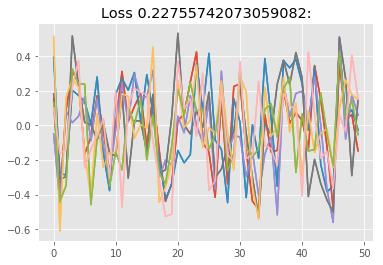

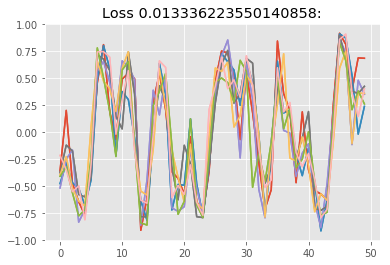

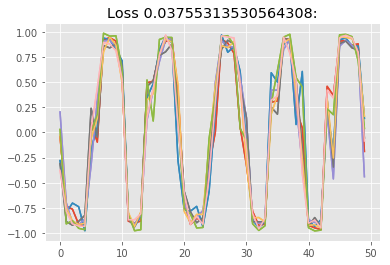

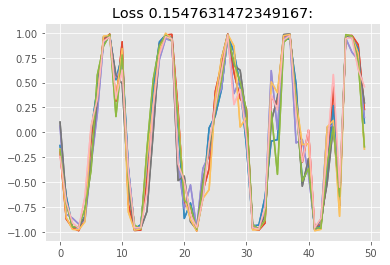

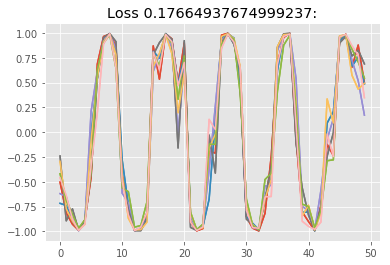

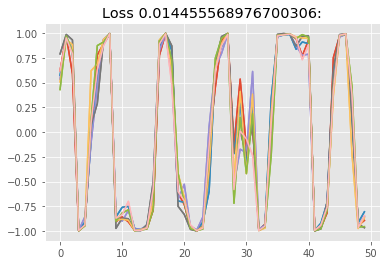

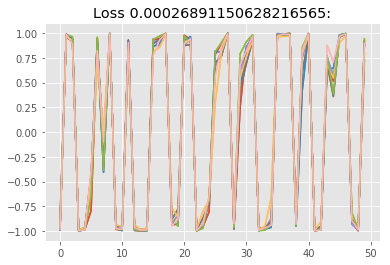

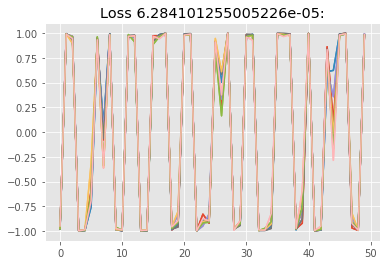

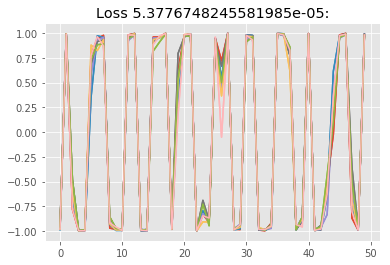

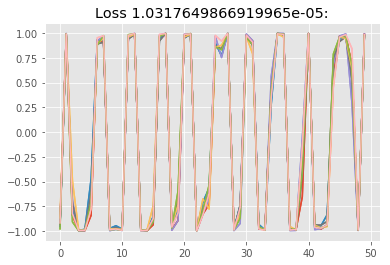

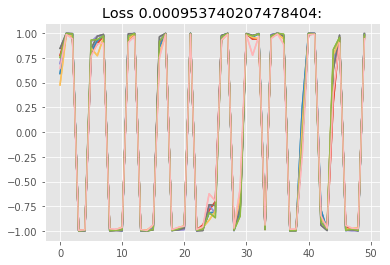

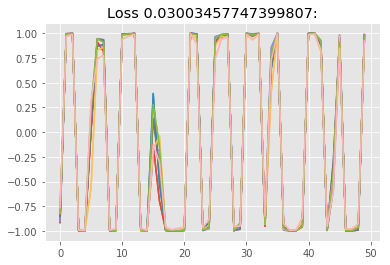

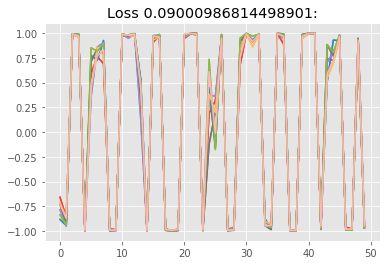

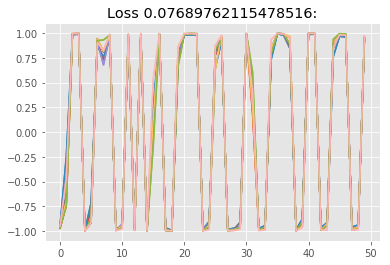

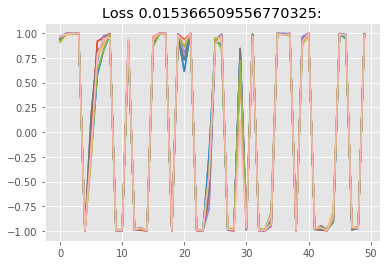

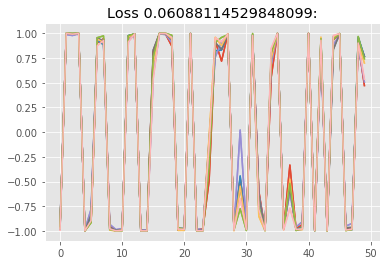

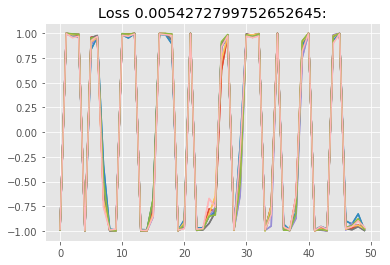

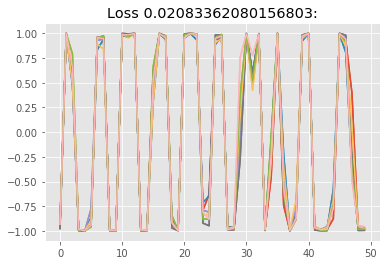

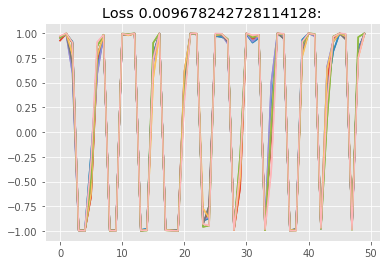

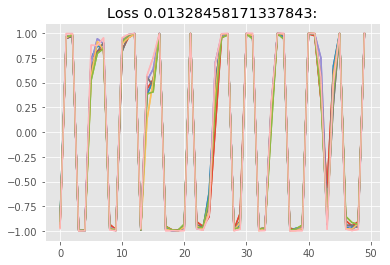

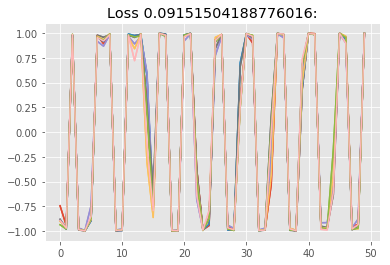

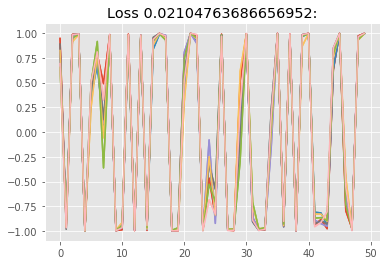

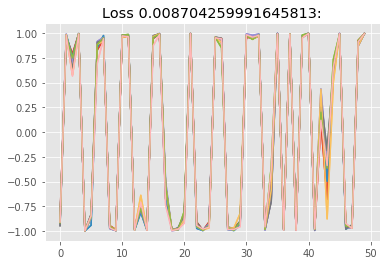

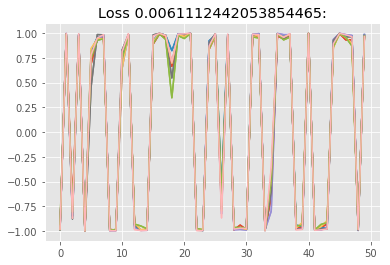

KeyboardInterrupt: 

In [127]:
e_bar = tqdm_notebook(range(1000))
G_losses = [1]
D_losses = [1]
logger = Logger('GAN-RNN-SIN')
for j, it in enumerate(e_bar):
    G_loss_avg = 0
    D_loss_avg = 0
    n_batches = 100
    b_bar = tqdm_notebook(range(n_batches), leave=False)
    
    DD = D_losses[-1]
    GG = G_losses[-1]
    
    for i in b_bar:
        z = Variable(g_noise()).cuda()
        X, c = real_sample()
        X = Variable(X.cuda())
        c = Variable(c.cuda())
        
        G_sample = G(z, c)
        D_real = D(X, c)
        D_fake = D(G_sample, c)
        D_loss_real = F.binary_cross_entropy(D_real, ones_label)
        D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label)     
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward(retain_graph=True)
        D_solver.step()
        D_loss = D_loss.data[0]
        reset_grad()
        
        for _ in range(1):
            z = Variable(g_noise()).cuda()
            G_sample = G(z, c)
            D_fake = D(G_sample, c)
            G_loss = F.binary_cross_entropy(D_fake, ones_label)
            G_loss.backward()
            G_solver.step()
            G_loss = G_loss.data[0]
            reset_grad()
        
        D_loss_avg += D_loss
        G_loss_avg += G_loss
        
        
    G_losses.append(G_loss_avg / n_batches)
    D_losses.append(D_loss_avg / n_batches)
    G_loss_avg = 0
    D_loss_avg = 0
    
    t = D_fake.mean().data.cpu().numpy().flatten()[0]
    if j%10 == 0:
        show_seqs(G_sample, j, t, ds=10)
    logger.log_scalar('loss/Disciminator', D_losses[-1])
    logger.log_scalar('loss/Generator', G_losses[-1])
    e_bar.set_postfix(
        G_loss=G_losses[-1],
        D_loss=D_losses[-1],
    )

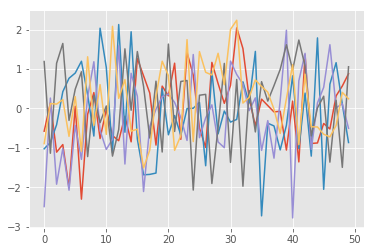

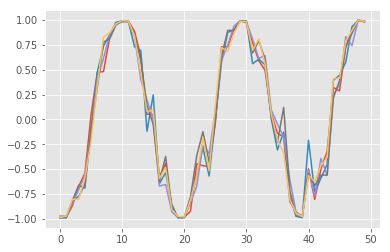

In [101]:
for _ in range(1):
    z = Variable(g_noise()).cuda() 
    ex = 5
    c = Variable(torch.ones(ex)).long().cuda() * 2
    G_sample = G(z[0:ex,:], c)
    ds = 1
    show_seqs_nosave(z[0:ex], ds=ds)
    show_seqs_nosave(G_sample[0:ex], ds=ds)

In [ ]:
for _ in range(1):
    z = Variable(g_noise()).cuda()
    c = Variable(torch.ones(5)).long().cuda() * 2
    G_sample = G(z[0:5,:], c)
    ds = 1
    show_seqs_nosave(z, ds=ds)
    show_seqs_aux(z[0:5],'input_noise', 'noise', ds=ds)
    #show_seqs_aux(G_sample,'gen', 'condition: 2', ds=ds)